# Quant Investment Strategy Hackathon Framework

This notebook demonstrates how to use the Quant Investment Strategy Framework for developing and testing investment strategies. The framework is designed to be easy to use, especially for participants with limited technical experience.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Import our framework
from quant_strategy_framework import QuantStrategyFramework, BaseStrategy
# Import hawk_backtester
import hawk_backtester as hbt


## 1. Loading and Preparing Data

In a real hackathon, you would be provided with a dataset. For this example, we'll create some sample data.

In [5]:
# Generate sample data
# This simulates the data that would be provided in the hackathon

# Define parameters
start_date = '2023-01-01'
end_date = '2023-03-31'
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Generate dates (excluding weekends for simplicity)
dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' for business days

# Create empty dataframe
data = []

# Seed for reproducibility
np.random.seed(42)

# Generate data for each asset
for asset in assets:
    # Start with a base price
    base_price = np.random.uniform(50, 200)
    
    # Generate a price series with some randomness
    price_series = [base_price]
    for i in range(1, len(dates)):
        # Random daily return between -3% and +3%
        daily_return = np.random.uniform(-0.03, 0.03)
        new_price = price_series[-1] * (1 + daily_return)
        price_series.append(new_price)
    
    # Generate OHLCV data
    for i, date in enumerate(dates):
        close = price_series[i]
        # Generate Open, High, Low around Close
        daily_volatility = close * np.random.uniform(0.005, 0.02)
        open_price = close * (1 + np.random.uniform(-0.01, 0.01))
        high_price = max(open_price, close) + daily_volatility
        low_price = min(open_price, close) - daily_volatility
        volume = np.random.randint(100000, 10000000)
        
        # Add some features that might be useful for strategies
        # 10-day moving average (will be NaN for first 9 days)
        ma10 = np.nan
        if i >= 9:
            ma10 = np.mean(price_series[i-9:i+1])
        
        # 30-day moving average (will be NaN for first 29 days)
        ma30 = np.nan
        if i >= 29:
            ma30 = np.mean(price_series[i-29:i+1])
        
        # Momentum (price change over last 5 days)
        momentum = np.nan
        if i >= 5:
            momentum = (close / price_series[i-5] - 1) * 100  # as percentage
        
        # Volatility (standard deviation of returns over last 10 days)
        volatility = np.nan
        if i >= 10:
            returns = [price_series[j+1]/price_series[j] - 1 for j in range(i-10, i)]
            volatility = np.std(returns) * 100  # as percentage
            
        # Create row
        data.append({
            'Date': date,
            'ticker': asset,  # Using 'ticker' instead of 'Asset'
            'Open': open_price,
            'High': high_price,
            'Low': low_price,
            'Close': close,
            'Volume': volume,
            'MA10': ma10,
            'MA30': ma30,
            'Momentum': momentum,
            'Volatility': volatility
        })

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()

,Date,ticker,Open,High,Low,Close,Volume,MA10,MA30,Momentum,Volatility
0,2023-01-02,AAPL,105.418477,107.576283,104.023212,106.181018,6180526,NaN,NaN,NaN,NaN
1,2023-01-03,AAPL,107.996035,109.868060,107.180432,109.052456,6656168,NaN,NaN,NaN,NaN
2,2023-01-04,AAPL,109.904164,112.404090,108.070500,110.570427,7040119,NaN,NaN,NaN,NaN
3,2023-01-05,AAPL,110.555024,111.804564,109.975409,111.224949,1837095,NaN,NaN,NaN,NaN
4,2023-01-06,AAPL,109.520377,111.256179,107.193589,108.929391,2331785,NaN,NaN,NaN,NaN


## 2. Creating a Simple Strategy

Let's create a basic strategy using our framework. We'll implement a momentum strategy that invests in assets with the strongest recent performance.

In [6]:
class MomentumStrategy(BaseStrategy):
    """
    A simple momentum strategy that allocates weights based on recent price momentum.
    """
    def construct_insights(self, model_state, current_date):
        """
        Implement the momentum strategy logic.
        
        Args:
            model_state: DataFrame with data up to current_date
            current_date: The current trading day
            
        Returns:
            Dict containing portfolio weights and timestamp
        """
        # Get the latest data for each asset
        latest_data = model_state.groupby('ticker').last().reset_index()
        
        # Filter out assets with missing momentum data
        latest_data = latest_data.dropna(subset=['Momentum'])
        
        # If no valid data, return empty weights
        if len(latest_data) == 0:
            return {
                'timestamp': current_date,
                'weights': {}
            }
        
        # Rank assets by momentum (higher is better)
        ranked_assets = latest_data.sort_values('Momentum', ascending=False)
        
        # Allocate more weight to assets with higher momentum
        weights = {}
        total_assets = len(ranked_assets)
        
        # Initialize all weights to 0
        for _, row in latest_data.iterrows():
            weights[row['ticker']] = 0.0
        
        if total_assets > 0:
            # Top asset gets 50%
            top_asset = ranked_assets.iloc[0]['ticker']
            weights[top_asset] = 0.5
            
            # Second asset gets 30%
            if total_assets > 1:
                second_asset = ranked_assets.iloc[1]['ticker']
                weights[second_asset] = 0.3
                
                # Remaining assets share 20% equally
                if total_assets > 2:
                    remaining_weight = 0.2
                    for i in range(2, total_assets):
                        asset = ranked_assets.iloc[i]['ticker']
                        weights[asset] = remaining_weight / (total_assets - 2)
        
        return {
            'timestamp': current_date,
            'weights': weights
        }

## 3. Running the Strategy

Now let's initialize and run our strategy.

In [7]:
# Create an instance of our strategy
momentum_strategy = MomentumStrategy()

# Initialize the framework with our data and strategy
# We'll start from February 1, 2023 to ensure we have enough data for our features
framework = QuantStrategyFramework(
    data=df,
    strategy=momentum_strategy,
    date_column='Date',
    start_date='2023-02-01'
)

# Run the strategy to generate insights
insights_df = framework.run_strategy()

# Display the first few rows
insights_df.head()

,date,AMZN,META,AAPL,MSFT,GOOGL
0,2023-02-01,0.500000,0.066667,0.066667,0.3,0.066667
1,2023-02-02,0.300000,0.066667,0.066667,0.5,0.066667
2,2023-02-03,0.300000,0.066667,0.066667,0.5,0.066667
3,2023-02-06,0.066667,0.300000,0.066667,0.5,0.066667
4,2023-02-07,0.066667,0.500000,0.066667,0.3,0.066667


In [8]:
# Get total number of trading days
print(f"Total trading days: {len(insights_df)}")

# Display summary statistics
print("\nSummary statistics for portfolio weights:")
insights_df.describe()

Total trading days: 43

Summary statistics for portfolio weights:


,date,AMZN,META,AAPL,MSFT,GOOGL
count,43,43.000000,43.000000,43.000000,43.000000,43.000000
mean,2023-03-02 08:55:48.837209344,0.244186,0.235659,0.165116,0.148837,0.206202
min,2023-02-01 00:00:00,0.066667,0.066667,0.066667,0.066667,0.066667
25%,2023-02-15 12:00:00,0.066667,0.066667,0.066667,0.066667,0.066667
50%,2023-03-02 00:00:00,0.300000,0.066667,0.066667,0.066667,0.066667
75%,2023-03-16 12:00:00,0.300000,0.500000,0.300000,0.066667,0.300000
max,2023-03-31 00:00:00,0.500000,0.500000,0.500000,0.500000,0.500000
std,NaN,0.169456,0.194827,0.161172,0.158423,0.178805


## 4. Visualizing the Strategy Allocations

Let's visualize how our portfolio allocations change over time.

<Figure size 1200x600 with 0 Axes>

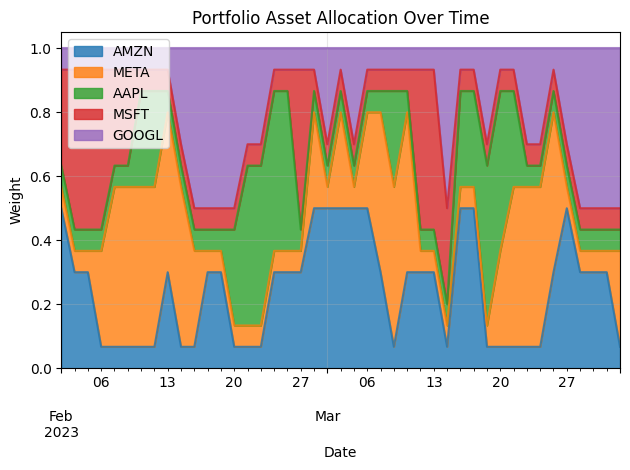

In [9]:
# Plot portfolio weights over time
plt.figure(figsize=(12, 6))

# Remove the date column for plotting
plot_df = insights_df.set_index('date')

# Create a stacked area chart
plot_df.plot.area(stacked=True, alpha=0.8)

plt.title('Portfolio Asset Allocation Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Creating a Different Strategy

Now let's implement a different strategy to demonstrate the flexibility of the framework. This time we'll create a mean-reversion strategy that buys assets that have recently underperformed.

In [10]:
class MeanReversionStrategy(BaseStrategy):
    """
    A mean reversion strategy that buys assets that have recently underperformed,
    assuming they will revert to their mean.
    """
    def construct_insights(self, model_state, current_date):
        """
        Implement the mean-reversion strategy logic.
        
        Args:
            model_state: DataFrame with data up to current_date
            current_date: The current trading day
            
        Returns:
            Dict containing portfolio weights and timestamp
        """
        # Get the latest data for each asset
        latest_data = model_state.groupby('ticker').last().reset_index()
        
        # Filter out assets with missing data
        latest_data = latest_data.dropna(subset=['Momentum', 'MA10', 'MA30'])
        
        # If no valid data, return empty weights
        if len(latest_data) == 0:
            return {
                'timestamp': current_date,
                'weights': {}
            }
        
        # Calculate the percentage below MA30 for each asset
        latest_data['PctBelowMA30'] = (latest_data['MA30'] - latest_data['Close']) / latest_data['MA30'] * 100
        
        # Rank assets by how much they're below their MA30 (higher value = more below)
        ranked_assets = latest_data.sort_values('PctBelowMA30', ascending=False)
        
        # Initialize weights
        weights = {asset: 0.0 for asset in latest_data['ticker']}
        
        # Only invest in assets that are below their MA30
        below_ma = ranked_assets[ranked_assets['PctBelowMA30'] > 0]
        
        if len(below_ma) > 0:
            # Calculate total percentage below MA30
            total_pct_below = below_ma['PctBelowMA30'].sum()
            
            if total_pct_below > 0:
                # Allocate weights proportional to how far below MA30 each asset is
                for _, row in below_ma.iterrows():
                    asset = row['ticker']
                    weight = row['PctBelowMA30'] / total_pct_below
                    weights[asset] = weight
            else:
                # Equal weights if we can't calculate proportions
                for _, row in below_ma.iterrows():
                    asset = row['ticker']
                    weights[asset] = 1.0 / len(below_ma)
        
        return {
            'timestamp': current_date,
            'weights': weights
        }

In [11]:
# Create an instance of our mean reversion strategy
mean_rev_strategy = MeanReversionStrategy()

# Initialize the framework with the mean reversion strategy
mean_rev_framework = QuantStrategyFramework(
    data=df,
    strategy=mean_rev_strategy,
    date_column='Date',
    start_date='2023-02-15'  # Starting a bit later to have more MA data
)

# Run the strategy
mean_rev_insights_df = mean_rev_framework.run_strategy()

# Display the first few rows
mean_rev_insights_df.head()

,date,AMZN,META,AAPL,MSFT,GOOGL
0,2023-02-15,0.00000,0.0,0.887998,0.000000,0.112002
1,2023-02-16,0.00000,0.0,1.000000,0.000000,0.000000
2,2023-02-17,0.00000,0.0,0.879566,0.120434,0.000000
3,2023-02-20,0.00000,0.0,0.412114,0.587886,0.000000
4,2023-02-21,0.04346,0.0,0.521020,0.298659,0.136861


<Figure size 1200x600 with 0 Axes>

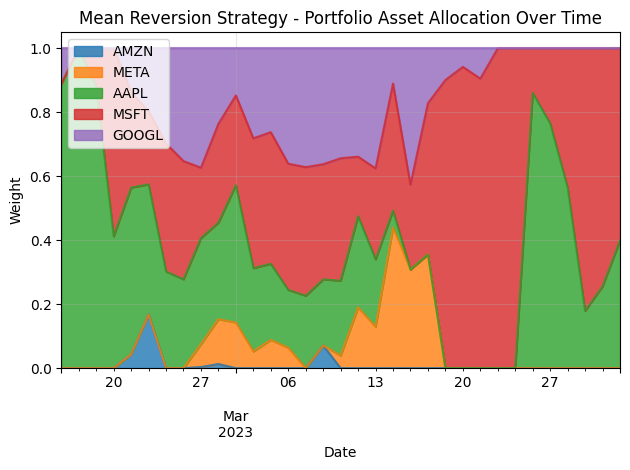

In [12]:
# Visualize the mean reversion strategy allocations
plt.figure(figsize=(12, 6))

# Remove the date column for plotting
mean_rev_plot_df = mean_rev_insights_df.set_index('date')

# Create a stacked area chart
mean_rev_plot_df.plot.area(stacked=True, alpha=0.8)

plt.title('Mean Reversion Strategy - Portfolio Asset Allocation Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Comparing Strategies

Let's compare the allocation patterns of our two different strategies.

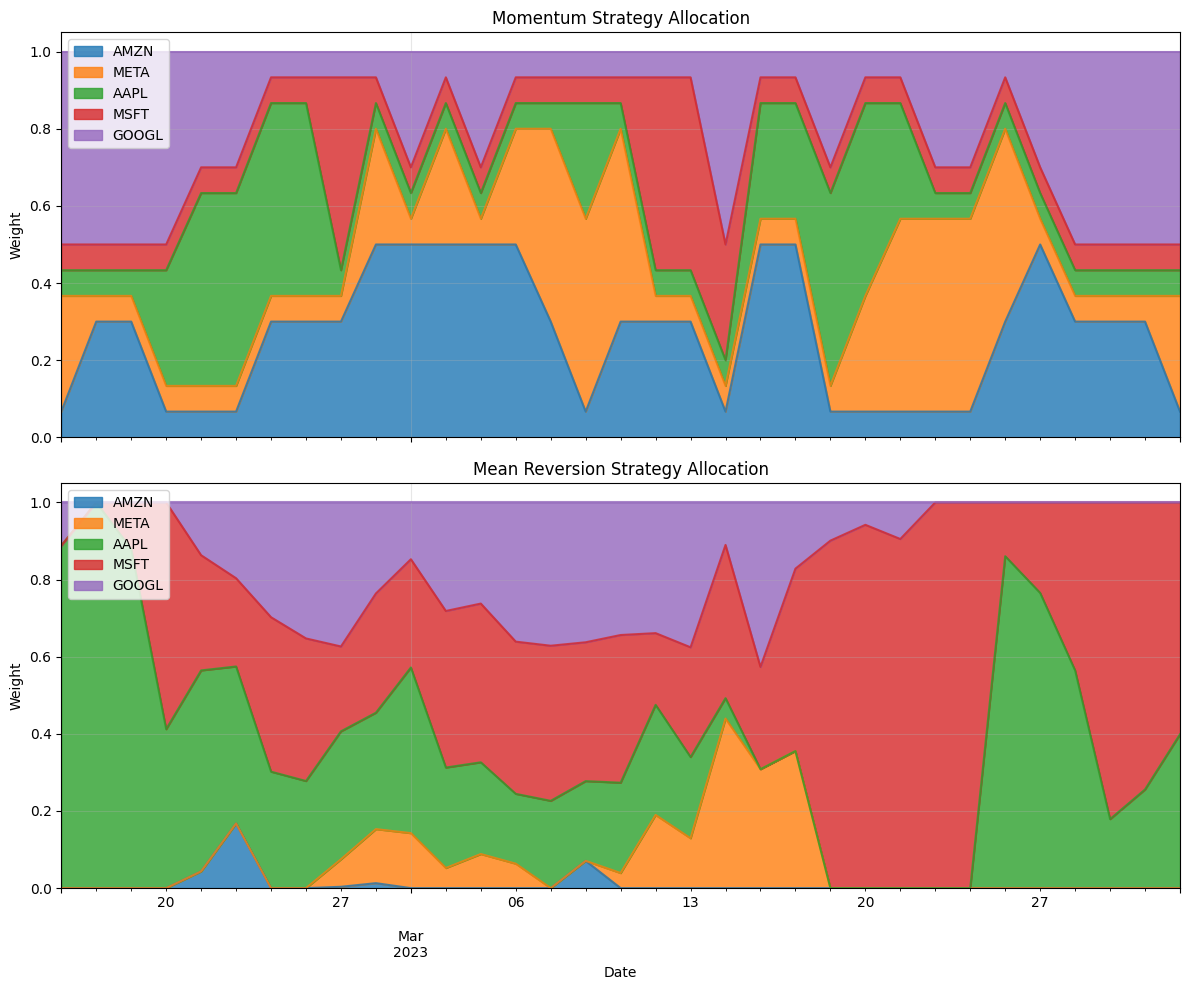

In [13]:
# Find the common date range between both strategies
common_start = max(insights_df['date'].min(), mean_rev_insights_df['date'].min())
common_end = min(insights_df['date'].max(), mean_rev_insights_df['date'].max())

# Filter to common date range
momentum_filtered = insights_df[(insights_df['date'] >= common_start) & (insights_df['date'] <= common_end)]
mean_rev_filtered = mean_rev_insights_df[(mean_rev_insights_df['date'] >= common_start) & (mean_rev_insights_df['date'] <= common_end)]

# Setup subplots for comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot momentum strategy
momentum_plot = momentum_filtered.set_index('date')
momentum_plot.plot.area(stacked=True, alpha=0.8, ax=axes[0])
axes[0].set_title('Momentum Strategy Allocation')
axes[0].set_ylabel('Weight')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot mean reversion strategy
mean_rev_plot = mean_rev_filtered.set_index('date')
mean_rev_plot.plot.area(stacked=True, alpha=0.8, ax=axes[1])
axes[1].set_title('Mean Reversion Strategy Allocation')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weight')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Exporting Results

You can easily export the insights DataFrame to a CSV file for further analysis or submission:

In [14]:
# Export momentum strategy insights
insights_df.to_csv('momentum_strategy_insights.csv', index=False)

# Export mean reversion strategy insights
mean_rev_insights_df.to_csv('mean_reversion_strategy_insights.csv', index=False)

print("Strategy insights exported to CSV files.")

Strategy insights exported to CSV files.


## 8. Conclusion

This notebook demonstrates how to use the Quant Investment Strategy Framework to develop and test investment strategies. The framework makes it easy to:

1. Load and prepare financial data
2. Implement different strategy logics by implementing the `BaseStrategy` abstract class
3. Iterate through trading days with proper data slicing
4. Generate portfolio weight insights in a structured DataFrame format
5. Visualize and analyze strategy allocations over time

In a hackathon setting, participants would focus on developing their own strategy logic by creating a class that inherits from `BaseStrategy` and implementing the `construct_insights` method, while the framework handles the data management and iteration.

## 9. Backtesting using hawk-backtester



In [ ]:
hbt.HawkBacktester(
    
)